In [66]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as LM
from sklearn import preprocessing as prp
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

np.seterr(divide = 'raise')
%matplotlib inline

## идея работы такая:
1) подгружаем данные из hdf файла

2) обучаем SGD classifier на имеющемся объёме данных

3) Тестируем полученную модель:
    - оформить всю процедуру от исходных сырых данных до конечного сета features в удобоваримый функционал
    - случайно выбираем пользователя 
    - получить предсказания модели
    - оценки модели

In [2]:
# import products description
products    =  pd.read_csv('./data/products.csv',index_col='product_id')
aisles      =  pd.read_csv('./data/aisles.csv',index_col = 'aisle_id')
departments =  pd.read_csv('./data/departments.csv', index_col = 'department_id')

aislesList = np.hstack([np.zeros(1), aisles.index.values])
departmentsList = departments.index.values

In [3]:
trainFile = "w:\Fedor\Kaggel\instacart\\newFeatures2.hdf"
trainDf = pd.read_hdf(trainFile)
trainDf.reset_index(drop=True,inplace=True)
print  trainDf.shape

(742262, 6)


In [30]:
def preprocessData(inp):
    df = inp.merge(products,left_on='product_id',right_index=True)
    df = df.assign(decay = df.lastOrder/df.periodicity).replace([np.inf, -np.inf], 0)
    df.fillna(0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    aisleEncoder =  prp.OneHotEncoder(sparse = False,n_values=aislesList.shape[0])
    
    aisleDf = pd.DataFrame(
        aisleEncoder.fit_transform(df.loc[:,'aisle_id'].values.reshape(-1, 1)),
        columns =['aisle_'+str(int(x)) for x in aislesList])
    
    aisleDf.drop('aisle_0', axis = 1, inplace=True)
    
    df = df.merge(aisleDf,left_index=True,right_index =True)
    X  = df.drop(['product_id','product_name','aisle_id','department_id'],axis = 1)
    
    return X

In [62]:
def calcf1Score(uGr):
    intersection = float((uGr.wasOrdered & uGr.wasPredicted).sum())
    predicted = uGr.wasPredicted.sum() 

    if predicted:
        precession   = intersection/predicted    
    else:
        precession  = 0.0

    basketSize = uGr.wasOrdered.sum()

    if basketSize:
        recall = intersection/basketSize
    else:
        recall = 0.0

    if (bool(precession) | bool(recall)):
        f1 = 2*precession*recall/(precession+recall)
    else:
        f1 = 0.0
    return f1

In [37]:
X = preprocessData(trainDf.drop(['wasOrdered'],axis = 1))
y = trainDf.wasOrdered.apply(lambda x: 1 if x else 0)

In [63]:
def testModel(estimator,X,y,n_splits = 3):
    skf = StratifiedKFold(n_splits = n_splits,random_state=None, shuffle=False)
    
    for train_index, test_index in skf.split(X, y):
        print 'Fold' 
        # split folds
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        # fit and predict
        estimator.fit(X_train.drop('userId',axis = 1),y_train)
        y_pr = estimator.predict(X_test.drop('userId',axis = 1))
        
        # estimate quality
        
        userGroups = X_test.assign(wasPredicted = y_pr.astype(bool), 
                                   wasOrdered = y_test ).groupby('userId')
        f1 = userGroups.apply(lambda x: calcf1Score(x))
        #print f1
        print f1.mean()

# SGD classifier

In [65]:
classifier = LM.SGDClassifier()
testModel(classifier,X,y)

Fold
0.0027140509516
Fold
0.000483714466619
Fold
0.0373068463813


## Decision tree

In [ ]:
tree = DecisionTreeClassifier()
testModel(tree,X,y)

Fold


0.0


(array([  46711.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  695551.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]),
 <a list of 10 Patch objects>)

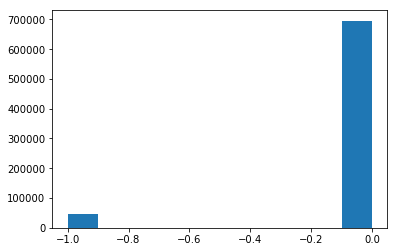

In [7]:
# create SGD classifier
classifier.fit(features,ans);
y_pr = classifier.predict(features) 
print f1_score(ans,y_pr)



## Что надо делать?
Оценка эффективности модели. Как?
Предсказания надо конвертнуть в структуру, содержащую информацию о пользователе. Сгруппировать по пользователям, посчитать для каждого f1 score, вычислить среднее значение.

In [ ]:
# на вход поступает trainDf и ответы y_pr

In [ ]:
y_pr = classifier.predict(features) 


In [ ]:
def save2File(fName,df):
    f = open(fName,'w')
    f.write('order_id,products\n')
    np.set_printoptions(linewidth = 500)
    for key, val in df.iteritems():
        k = np.array2string(val[1])[1:-1]+'\n'
        s = str(val[0])+','+k
        f.write(s)
    f.close()
    np.set_printoptions(linewidth = 75)

In [ ]:
def f1Score(y_true, y_pred):
    fullSet      = np.unique(np.hstack((y_pred,y_true)))
    intersection = np.intersect1d(y_true,y_pred).size
    precession   = intersection/float(y_pred.shape[0])
    recall       = intersection/float(y_true.shape[0])
    try:
        f1 = 2*precession*recall/(precession+recall)
    except ZeroDivisionError:
        f1 = 0
    return [precession, recall, f1]

In [ ]:
orders = pd.read_csv('./data/orders.csv',index_col = 'order_id',usecols = ['order_id','user_id','eval_set','order_number','days_since_prior_order'])
orders.loc[:,'days_since_prior_order'].fillna(0,inplace = True) 
orders = orders.assign(date = orders.groupby('user_id').days_since_prior_order.transform(np.cumsum))

In [ ]:
# now I want to test the model
trainUserId = orders.query("eval_set == 'train'").user_id.values
#testPriorOrderId = orders.query("(eval_set =='prior') and user_id in @testUsers").index.values
#testPriorSet = prior.query('order_id in @testPriorOrderId')

In [ ]:
testUsers = trainUserId[-50:-10]
testOrders = orders.query('user_id in @testUsers')

In [ ]:
usecols = ['order_id','product_id']
items = pd.concat([pd.read_csv('./data/order_products__train.csv',usecols = usecols),
                   pd.read_csv('./data/order_products__prior.csv',usecols = usecols)])

In [ ]:
newDf = pd.DataFrame(columns = ['product_id','periodicity','absCount','lastOrder','wasOrdered'])
for tId, userGroup in testOrders.groupby('user_id'):
    print tId
    # вот это можно вычислить один раз для пользователя
    trainOrder = userGroup.query("eval_set != 'prior'")
    trainOrderDay = trainOrder.date.values

    # получаем предзаказы
    preOrders = userGroup.query("eval_set == 'prior' ").fillna(0).merge(
        items,left_index=True,right_on='order_id',copy = False,how='inner')

    fullBasket = preOrders.product_id.unique()

    r2 = preOrders.groupby('product_id').agg(
        {'date': lambda x: np.diff(x.values).mean(),
         'order_number': lambda x: x.shape[0]}
        ).rename(columns={'date': 'periodicity','order_number':'absCount'})

    r3 = preOrders.groupby('product_id').agg(
        {'date': lambda x: int(trainOrderDay - x.iloc[-1])}
        ).rename(columns={'date':'lastOrder'})

    r2 = r2.merge(r3,left_index=True,right_index=True)
    r2.reset_index(inplace=True)
    
    trainBasket = list(userGroup.query("(user_id == @tId) and eval_set != 'prior' ").fillna(0).merge(
        items,left_index=True,right_on='order_id',copy = False,how='inner').product_id.unique())

    r2 = r2.assign(wasOrdered = r2.product_id.apply(lambda x: x in trainBasket))
    # теперь можно рассчитать популярность каждого продукта в процентах
    #r2 = r2.assign(decay = r2.lastOrder/r2.periodicity)
    r2 = r2.assign(userId = tId)
    r2.fillna(0,inplace=True)
    r2.replace(np.inf,0,inplace=True)
    #r2.merge(products,left_on='product_id',right_index=True)
    #r2.to_hdf('newFeatures.hdf', 'features', format = 'table',append = True)
    newDf = pd.concat([newDf,r2])

In [ ]:
features_test = preprocessData(newDf.drop(['wasOrdered'],axis = 1))
ans_test = newDf.wasOrdered.apply(lambda x: 1 if x else 0)

In [ ]:
(classifier.predict(features)==ans).hist()

In [ ]:
(classifier.predict(features_test)==ans_test).hist()

In [16]:
f1

NameError: name 'f1' is not defined